In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pip
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
import os


In [2]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [3]:
from gensim.models import Word2Vec
from gensim.models import keyedvectors

In [4]:
donors_dataset=pd.read_csv('train_data.csv')
resources_dataset=pd.read_csv('resources.csv')
print(donors_dataset.shape)
print(donors_dataset.columns.values)
print(resources_dataset.shape)
print(resources_dataset.columns.values)
type(donors_dataset)


(109248, 17)
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
(1541272, 4)
['id' 'description' 'quantity' 'price']


pandas.core.frame.DataFrame

Number of projects that are  approved for funding  92706 , ( 84.85830404217927 %)
Number of projects that are not approved for funding  16542 , ( 15.141695957820739 %)


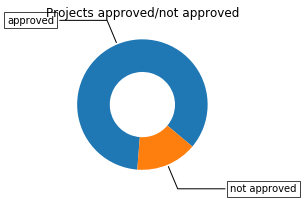

(109248, 17)


In [5]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

x_value_counts=donors_dataset['project_is_approved'].value_counts()
print("Number of projects that are  approved for funding ", x_value_counts[1], ", (", (x_value_counts[1]/(x_value_counts[1]+x_value_counts[0]))*100,"%)")
print("Number of projects that are not approved for funding ", x_value_counts[0], ", (", (x_value_counts[0]/(x_value_counts[1]+x_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
recipe=["approved","not approved"]
data=[x_value_counts[1],x_value_counts[0]]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
ax.set_title("Projects approved/not approved")

plt.show()  
print(donors_dataset.shape)

In [6]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039
temp = pd.DataFrame(donors_dataset.groupby("teacher_number_of_previously_posted_projects")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['teacher_number_of_previously_posted_projects', 'project_is_approved']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

clr_scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = clr_scl,
        autocolorscale = False,
        locations = temp['teacher_number_of_previously_posted_projects'],
        z = temp['project_is_approved'].astype(float),
        locationmode = 'USA-states',
        text = temp['teacher_number_of_previously_posted_projects'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='donors_dataset')
print(donors_dataset.shape)

(109248, 17)


In [7]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['teacher_number_of_previously_posted_projects'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))
print(donors_dataset.shape)

States with lowest % approvals
   teacher_number_of_previously_posted_projects  project_is_approved
0                                             0             0.821350
1                                             1             0.830054
2                                             2             0.841063
3                                             3             0.843460
4                                             4             0.845423
States with highest % approvals
     teacher_number_of_previously_posted_projects  project_is_approved
369                                           428                  1.0
370                                           432                  1.0
371                                           433                  1.0
372                                           437                  1.0
373                                           451                  1.0
(109248, 17)


In [8]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show() 
print(donors_dataset.shape)

(109248, 17)


In [9]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(donors_dataset.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(donors_dataset.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(donors_dataset.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
       
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))
print(donors_dataset.shape)


(109248, 17)


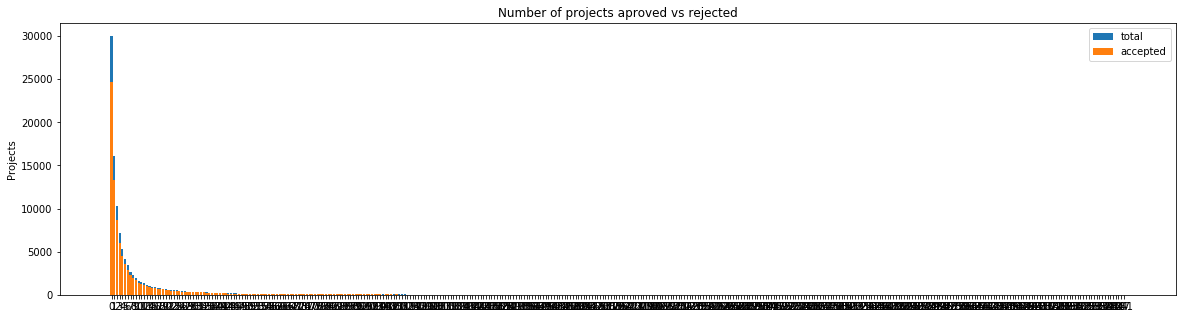

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
     teacher_number_of_previously_posted_projects  project_is_approved  total  \
242                                           242                    1      1   
268                                           270                    1      1   
234                                           234                    1      1   
335                                           347                    1      1   
373                                 

In [10]:
    univariate_barplots(donors_dataset, 'teacher_number_of_previously_posted_projects', 'project_is_approved',False)
    print(donors_dataset.shape)


In [11]:
#Summary:- atleast 80% of projects which have been posted previously by teachers, have been approved

In [12]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(donors_dataset.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(donors_dataset.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(donors_dataset.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
       
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))
    print(donors_dataset.shape)

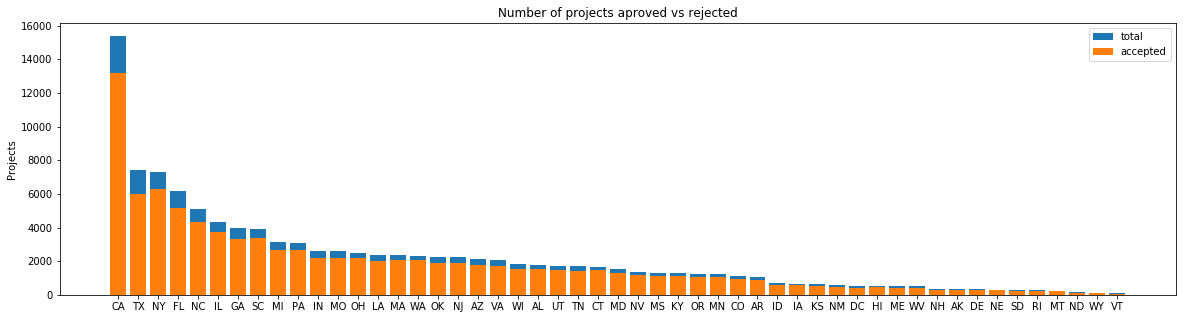

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000
(109248, 17)
(109248, 17)


In [13]:
univariate_barplots(donors_dataset, 'school_state', 'project_is_approved', False)
print(donors_dataset.shape)

In [14]:
#every state has atleast 80% success of project approval rate

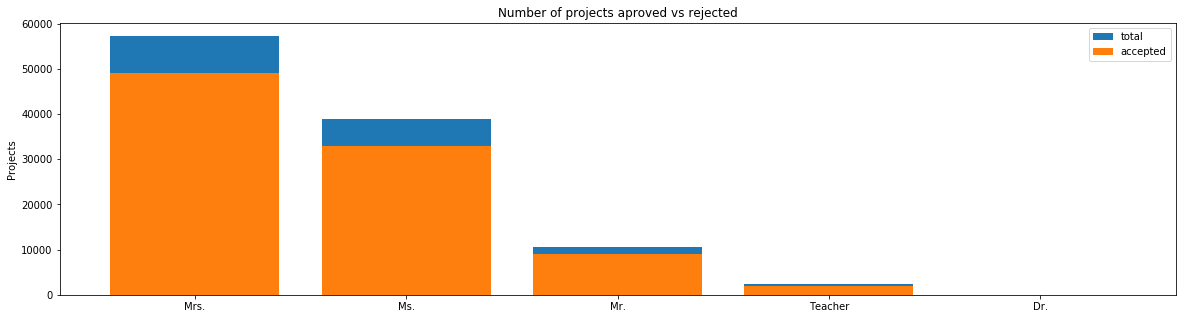

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
(109248, 17)
(109248, 17)


In [15]:
univariate_barplots(donors_dataset, 'teacher_prefix', 'project_is_approved' , top=False)
print(donors_dataset.shape)

In [16]:
#Observation:- Teachers with Mrs. prefix have higher average of project approval rate compared to teachers with Dr. prefix

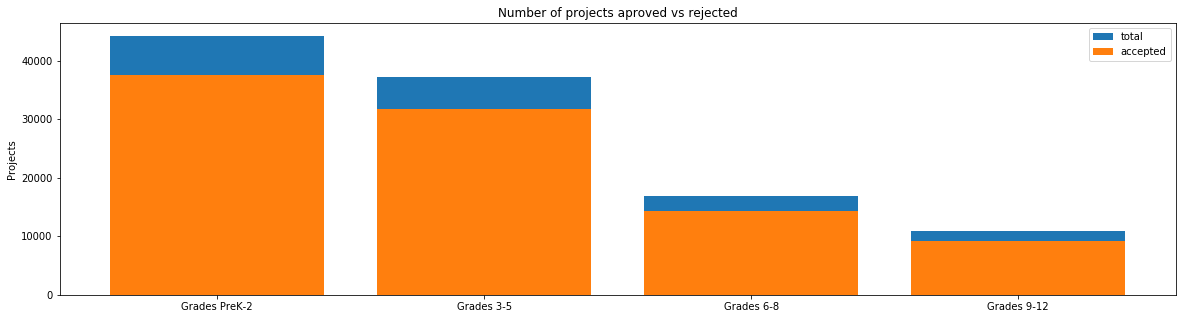

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
(109248, 17)
(109248, 17)


In [17]:
univariate_barplots(donors_dataset, 'project_grade_category', 'project_is_approved', top=False)
print(donors_dataset.shape)

In [18]:
#teachers designed projects for grade prek-2  has higher average success of project proposal acceptance rate than teachers who designed projetcs for grade 9-12

In [19]:
catogories = list(donors_dataset['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
print(donors_dataset.shape)

(109248, 17)


In [20]:
donors_dataset['clean_categories'] = cat_list
donors_dataset.drop(['project_subject_categories'], axis=1, inplace=True)
donors_dataset.head(2)
print(donors_dataset.shape)

(109248, 17)


In [21]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in donors_dataset['clean_categories'].values:
    my_counter.update(word.split())
print(donors_dataset.shape)

(109248, 17)


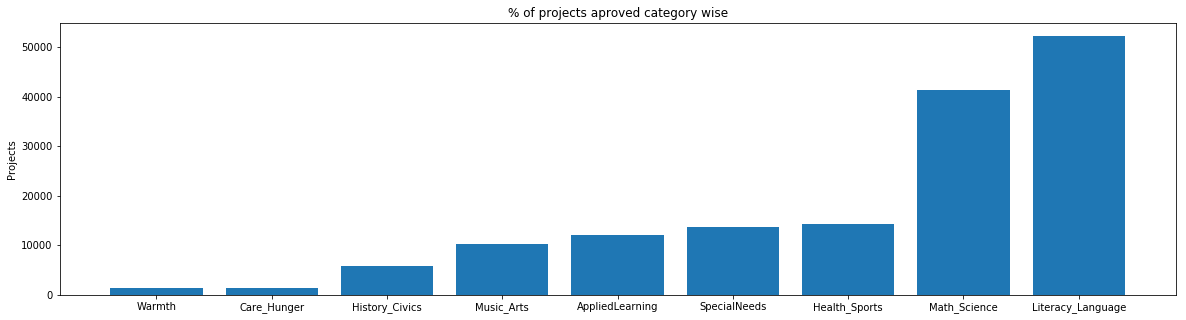

(109248, 17)


In [22]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()
print(donors_dataset.shape)

In [23]:
#number of projects approved for literacy language category is on highest whereas number of projects approved for warmth category is lowest

In [24]:
sub_catogories = list(donors_dataset['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
print(donors_dataset.shape)
    

(109248, 17)


In [25]:
donors_dataset['clean_subcategories'] = sub_cat_list
donors_dataset.drop(['project_subject_subcategories'], axis=1, inplace=True)
donors_dataset.head(2)
print(donors_dataset.shape)

(109248, 17)


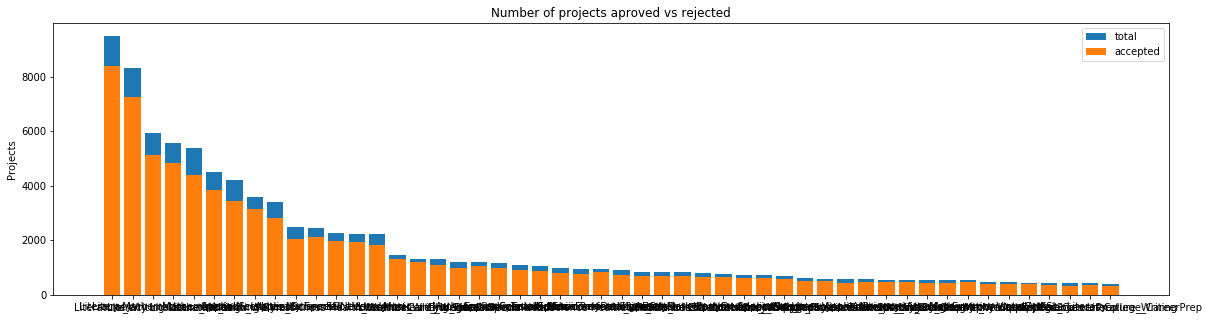

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815
(109248, 17)
(109248, 17)


In [26]:
univariate_barplots(donors_dataset, 'clean_subcategories', 'project_is_approved', top=50)
print(donors_dataset.shape)

In [27]:
#the average number of projects approved success overall rate across all subcategories is atleast 80%

In [28]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in donors_dataset['clean_subcategories'].values:
    my_counter.update(word.split())
print(donors_dataset.shape)

(109248, 17)


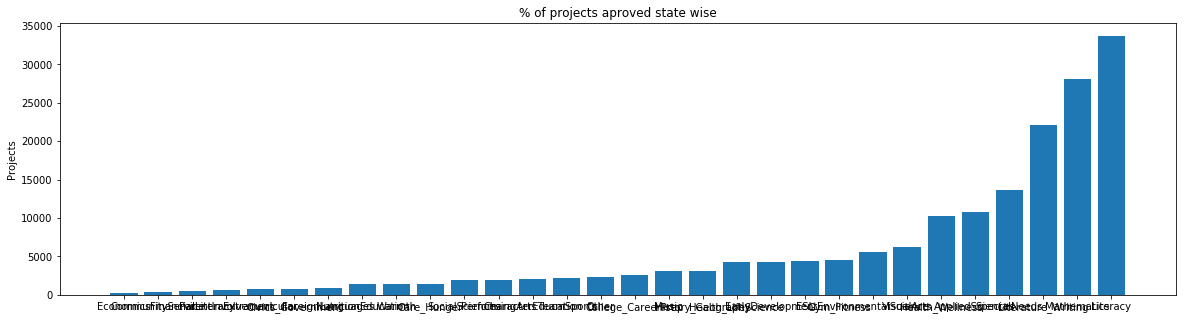

(109248, 17)


In [29]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()
print(donors_dataset.shape)

In [30]:
#the average number of projects approved statewise in literacy_language is highest and in warmth lowest respectively  

In [31]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))
print(donors_dataset.shape)
    

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700
(109248, 1

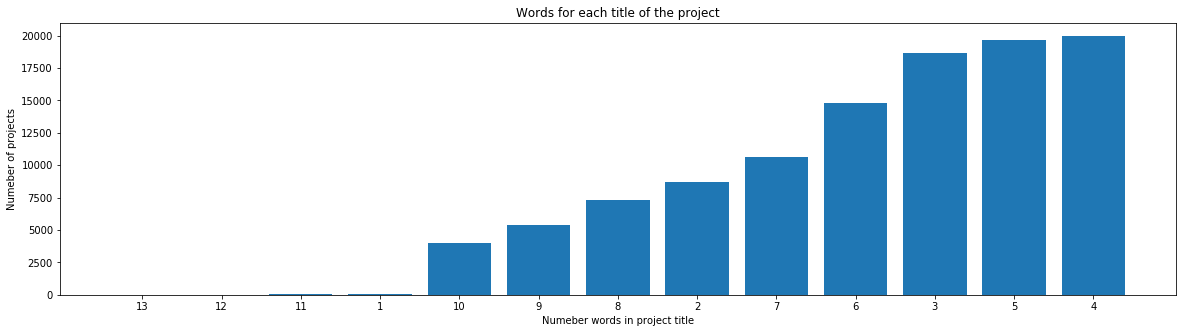

(109248, 17)


In [32]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = donors_dataset['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()
print(donors_dataset.shape)

In [33]:
#4 words project title has highest no. of projectd were as 11 word title has leaset no. of projects

In [34]:
approved_title_word_count = donors_dataset[donors_dataset['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = donors_dataset[donors_dataset['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values
print(donors_dataset.shape)

(109248, 17)


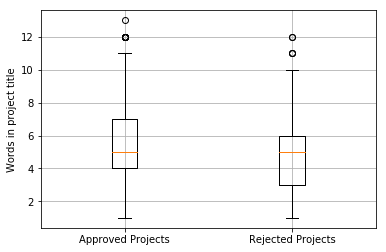

(109248, 17)


In [35]:
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()
print(donors_dataset.shape)

In [36]:
# 50th percentile of rejected projects with 5 word length,are higher in number compared to 50th percentile of approved projects with same word length

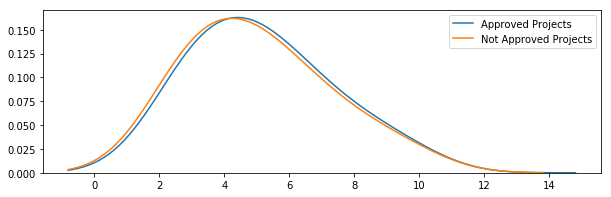

(109248, 17)


In [37]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()
print(donors_dataset.shape)

In [38]:
#among the projetcs,of title word count range(0-4), approved projetcs are slightly lower than projetcs which are not approved
#among the projetcs,of title word count range(4-10), approved projetcs are slightly higher than projetcs which are not approved
##among the projetcs,of title word count range(10-12),both approved prjects and projects which are not approved are almost same.


In [39]:
# merge two column text dataframe: 
donors_dataset["essay"] = donors_dataset["project_essay_1"].map(str) +\
                        donors_dataset["project_essay_2"].map(str) + \
                        donors_dataset["project_essay_3"].map(str) + \
                        donors_dataset["project_essay_4"].map(str)
print(donors_dataset.shape)

(109248, 18)


In [40]:
approved_word_count = donors_dataset[donors_dataset['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = donors_dataset[donors_dataset['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values
print(donors_dataset.shape)

(109248, 18)


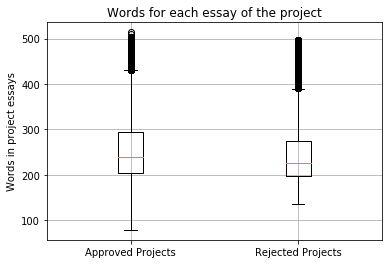

(109248, 18)


In [41]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()
print(donors_dataset.shape)

In [42]:
# approved projects have more than 500 words project essays compared to rejected projects which has atmax 500 wrds in project essay
#the number of words in project essays of approved projects is at higher than the number of words in project essays for rejected projects in terms of 50 and 75 percentiles respectively

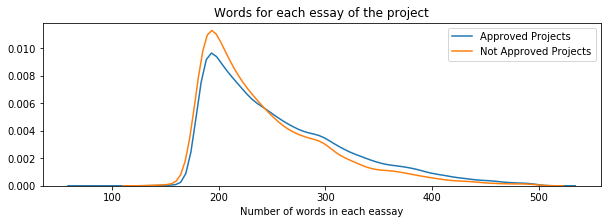

(109248, 18)


In [43]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()
print(donors_dataset.shape)

In [44]:
#number of words per essay, in range (100-250) for approved projects is on lower side compared to projects which were not approved
#number of words per essay, in range (250-500) for approved projetcs is on higher side compared to projects which were not approved

In [45]:
# we get the cost of the project using resource.csv file
resources_dataset.head(2)
print(donors_dataset.shape)

(109248, 18)


In [46]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resources_dataset.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
print(price_data.head())
print(donors_dataset.shape)

        id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8
(109248, 18)


In [47]:
print(resources_dataset[resources_dataset['id']=='p253737'])

              id                                description  quantity  price
1058029  p253737         Alphabet Circus Rock and Learn DVD         3  14.59
1058030  p253737         Getting Ready for Kindergarten DVD         3  14.59
1058031  p253737                LeapFrog Letter Factory DVD         3  14.98
1058032  p253737                    LeapFrog Word Caper DVD         3  14.98
1058033  p253737                          Letter Sounds DVD         3  14.59
1058034  p253737                       Phonics Volume 1 DVD         3  14.59
1058035  p253737  Sylvania - 10'Portable DVD Player - black         5  66.28


In [48]:
# join two dataframes in python: 
donors_dataset1 = pd.merge(donors_dataset, price_data, on='id', how='left')
donors_dataset1.head()
# print(donors_dataset[donors_dataset['id']=='p000157'])
# print(donors_dataset.shape)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05/12/2016 13:43          Grades PreK-2   
1           FL           25/10/2016 09:22             Grades 6-8   
2           AZ           31/08/2016 12:03             Grades 6-8   
3           KY           06/10/2016 21:16          Grades PreK-2   
4           TX           11/07/2016 01:10          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay   price  quantity  
0  My students are English learners that are work...  154.60        23  
1  Our students arrive to our school eager to lea...  299.00         1  
2  \r\n\"True champions aren't always the ones th...  516.85        22  
3  I work at a unique school filled with both ESL...  232.90         4  
4  Our second grade classroom next year will be m...   67.98         4

In [49]:
approved_price = donors_dataset1[donors_dataset['project_is_approved']==1]['price'].values
rejected_price = donors_dataset1[donors_dataset['project_is_approved']==0]['price'].values
print(approved_price[:10])
print(rejected_price[:10])
print(donors_dataset1.shape)



[299.   232.9   67.98 113.22 159.99 229.   241.98 125.36 100.21 431.77]
[154.6  516.85 219.46  91.94 278.09 268.99 129.98 589.   397.9  189.03]
(109248, 20)


In [50]:
#df=pd.DataFrame(donors_dataset)
#donors_dataset=df.sample(frac=0.04)

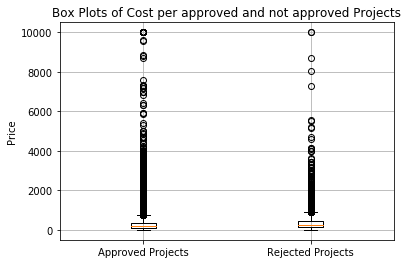

(109248, 20)


In [51]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()
print(donors_dataset1.shape)

In [52]:
#comparing the outliers cost  of approved projects and projetcs which were not approved,the cost of approved projects is on higher side.

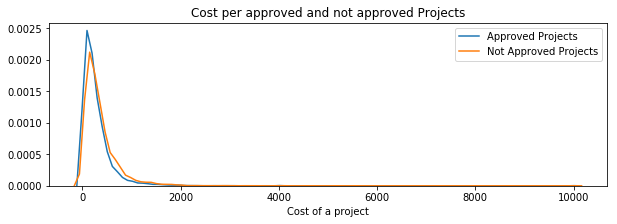

(109248, 20)


In [53]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()
print(donors_dataset1.shape)

In [54]:
#the maximum cost of approved projects is higher than maximum cost of rejected projects

In [55]:
!pip install prettytable

In [56]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)
print(donors_dataset1.shape)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

In [57]:
# Import stopwords with nltk.
#https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
stop = stopwords.words('english')
test=pd.DataFrame(donors_dataset)
#removal of stopwords from row-wise contents of project_resource_summary column,of donors_dataset
test.column=["project_resource_summary"]
test['clean_prj_res'] = test['project_resource_summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_test=test['clean_prj_res']
print(test.column[:10])
print(clean_test[:10])
print(donors_dataset.shape)
print(donors_dataset.columns.values)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['project_resource_summary']
0    My students need opportunities practice beginn...
1    My students need projector help viewing educat...
2    My students need shine guards, athletic socks,...
3    My students need engage Reading Math way inspi...
4    My students need hands practice mathematics. H...
5    My students need movement successful. Being I ...
6    My students need dependable laptops daily clas...
7    My students need ipads help access world onlin...
8    My students need three devices three managemen...
9    My students need great books use Independent R...
Name: clean_prj_res, dtype: object
(109248, 19)
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category' 'project_title'
 'project_essay_1' 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'projec

In [58]:
donors_dataset["clean_proj_res_essay"]=donors_dataset["clean_prj_res"]


In [59]:
approved_word_count = donors_dataset[donors_dataset['project_is_approved']==1]['clean_proj_res_essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = donors_dataset[donors_dataset['project_is_approved']==0]['clean_proj_res_essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

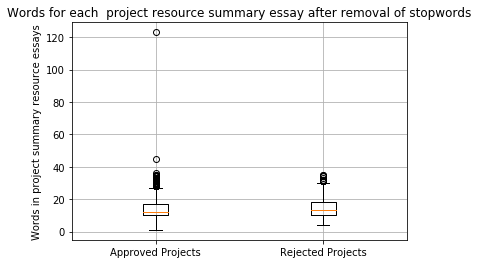

In [60]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each  project resource summary essay after removal of stopwords')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project summary resource essays')
plt.grid()
plt.show()

In [61]:
#number of words of project resource essay after removal of stopwords,at 50 percentile for rejected projects is at higher number compared to approved projects

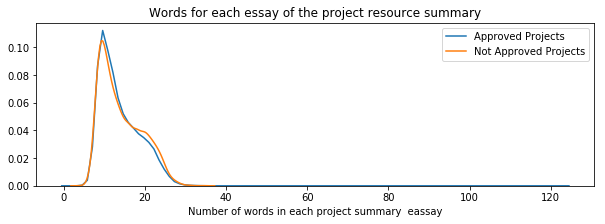

In [62]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project resource summary')
plt.xlabel('Number of words in each project summary  eassay')
plt.legend()
plt.show()

In [63]:
#The approved projects are higher in number which hasupto 20 words for each essay of the project resource summar, more than 20 words for each essay the projects which are not approved are in higher number compared to approved number of projects

In [64]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(donors_dataset['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(donors_dataset['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encodig  (109248, 51)


In [65]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(donors_dataset['clean_categories'].values)
print(vectorizer.get_feature_names())


clean_categories_one_hot = vectorizer.transform(donors_dataset['clean_categories'].values)
print("Shape of matrix after one hot encodig ",clean_categories_one_hot.shape)

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of matrix after one hot encodig  (109248, 9)


In [66]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(donors_dataset['clean_subcategories'].values)
print(vectorizer.get_feature_names())


clean_subcategories_one_hot = vectorizer.transform(donors_dataset['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",clean_subcategories_one_hot.shape)

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of matrix after one hot encodig  (109248, 30)


In [67]:
from sklearn.feature_extraction.text import CountVectorizer
donors_dataset['teacher_prefix'] = donors_dataset['teacher_prefix'].fillna('')
newcol=list(set(list(donors_dataset['teacher_prefix'])))
newcol = list(filter(None,newcol))
vectorizer = CountVectorizer(vocabulary=newcol, lowercase=False, binary=True)
vectorizer.fit(donors_dataset['teacher_prefix'].values.astype("U"))
print(vectorizer.get_feature_names())
teacher_prefix_categories_one_hot = vectorizer.transform(donors_dataset['teacher_prefix'].values.astype("U"))
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)


['Ms.', 'Dr.', 'Mrs.', 'Mr.', 'Teacher']
Shape of matrix after one hot encoding  (109248, 5)


In [68]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(donors_dataset['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_category_one_hot = vectorizer.transform(donors_dataset['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)

['12', 'Grades', 'PreK']
Shape of matrix after one hot encodig  (109248, 3)


In [69]:
donors_dataset.shape
donors_dataset.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN           05/12/2016 13:43          Grades PreK-2   
1           FL           25/10/2016 09:22             Grades 6-8   
2           AZ           31/08/2016 12:03             Grades 6-8   
3           KY           06/10/2016 21:16          Grades PreK-2   
4           TX           11/07/2016 01:10          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                       clean_prj_res  \
0  My students need opportunities practice beginn...   
1  My students need projector help viewing educat...   
2  My students need shine guards, athletic socks,...   
3  My students need engage Reading Math way inspi...   
4  My students need hands practice mathematics. H...   

                                clean_proj_res_essay  
0  My students need opportunities prac

In [70]:
print(donors_dataset1['project_title'].values[0])
print("="*50)
print(donors_dataset1['project_title'].values[50])
print("="*50)

Educational Support for English Learners at Home
Be Active! Be Energized!


In [71]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [72]:
sent = decontracted(donors_dataset['project_title'].values[50])
print(sent)
print("="*50)

Be Active! Be Energized!


In [73]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Be Active! Be Energized!


In [74]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Be Active Be Energized 


In [75]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [76]:
!pip install conda

In [77]:
!pip install tqdm

In [78]:
from tqdm import tqdm
preprocessed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(donors_dataset['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_title.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:05<00:00, 20083.27it/s]


In [79]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 3329)


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


In [81]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
price_scalar = StandardScaler()
price_scalar.fit(donors_dataset1['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above mean and variance.
price_standardized = price_scalar.transform(donors_dataset1['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [82]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
teacher_number_of_previously_posted_projects_scalar = StandardScaler()
teacher_number_of_previously_posted_projects_scalar.fit(donors_dataset['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
teacher_number = teacher_number_of_previously_posted_projects_scalar.transform(donors_dataset['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [83]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


Loading Glove Model


1917495it [14:05, 2267.16it/s]


Done. 1917495  words loaded!


In [84]:
words = []
for i in preprocessed_project_title:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))
inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")
words_corpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]
print("word 2 vec length", len(words_corpus))
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus, f)



all the words in the coupus 473560
the unique words in the coupus 16903
The number of words that are present in both glove vectors and our coupus 15917 ( 94.167 %)
word 2 vec length 15917


In [85]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [86]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
           vector += model[word]
        cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:05<00:00, 21032.42it/s]


109248
300


In [87]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_project_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [88]:
# average Word2Vec
# compute average word2vec for each project title.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each project title
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the project title
    for word in sentence.split(): # for each word in a project title
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))
print(type(tfidf_w2v_vectors))


100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:07<00:00, 14443.13it/s]


109248
300
<class 'list'>


In [89]:
#donors_dataset2=donors_dataset[0:5000]

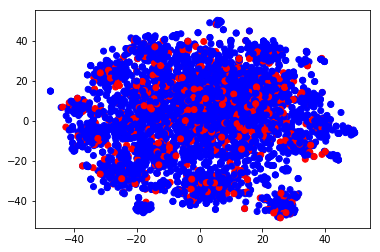

In [90]:
from sklearn.manifold import TSNE
from sklearn import datasets
x=text_bow.toarray()[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()



In [ ]:
#the bag of words vector of the column project title shows that,  those number  project titles whose projects were approved is higher than those number of project titles whose projects werent approved. There are few clusters of dense blue points(project titles whose projects were approved)

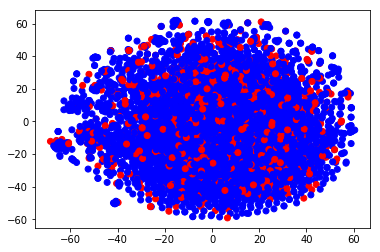

In [91]:
from sklearn.manifold import TSNE
from sklearn import datasets
#text_tf_new=text_tfidf[0,5000,:]
x=text_tfidf.toarray()[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()



In [ ]:
#the term frequency/inverse document frequency vector of the column project title shows that,  those number  project titles whose projects were approved is higher than those number of project titles whose projects werent approved.project titles with approved projects is denser at negative scale(at lower side) compared to positive scale(upper side). Red points refer to those project titles whose projects werent approved.

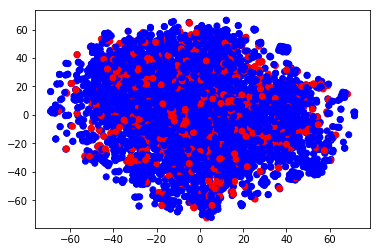

In [92]:
from sklearn.manifold import TSNE
from sklearn import datasets
#avg_w2v_new=avg_w2v_vectors[0,5000,:]
x=np.asarray(avg_w2v_vectors)[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

In [ ]:
#the word to  vector of the column project title shows that,  those number  project titles whose projects were approved is higher than those number of project titles whose projects werent approved. The blue points are denser at center which then becomes sparser at it goes away from center

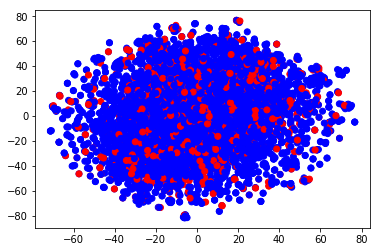

In [93]:
from sklearn.manifold import TSNE
from sklearn import datasets
#tfidf_w2v_new=tfidf_w2v_vectors[0,5000,:]
x=np.asarray(tfidf_w2v_vectors)[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()



In [ ]:
#the term frequency/inverse document frequqency word to  vector of the column project title shows that,  those number  project titles whose projects were approved is higher than those number of project titles whose projects werent approved. The blue points are denser at center it becomes sparser once is goes away from center.

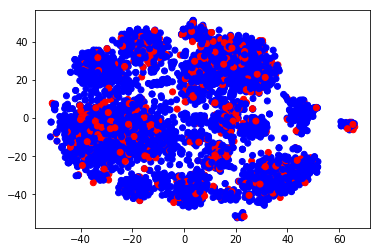

In [94]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((school_state_one_hot,clean_categories_one_hot, clean_subcategories_one_hot, teacher_prefix_categories_one_hot, project_grade_category_one_hot,text_bow,price_standardized,teacher_number))
#X_new=X[0,5000,:]
X.shape
from sklearn.manifold import TSNE
from sklearn import datasets
x=X.toarray()[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X1_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X1_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()


In [ ]:
# one hot encoding of the values in the columns school state,clean categories,clean subcategories,teachers prefix categories,project grade category are stacked together.
#the bag of words vector of project title category, price column from resources dataset is standardised, number of teacher column which is numerical ,all these columns are stacked with the above mentioned one hot encoding column
#t-sne plot on all these stacked columns show that blue points are more denser than red points, and they are in different clusters closer to each other,
#this shows that approved number of projects for all these columns stacked together is higher in than number of projects which were not approved

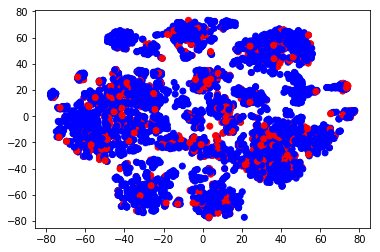

In [95]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((school_state_one_hot,clean_categories_one_hot, clean_subcategories_one_hot, teacher_prefix_categories_one_hot, project_grade_category_one_hot,text_tfidf,price_standardized,teacher_number))
#X_new1=X[0,5000,:]
X.shape
from sklearn.manifold import TSNE
from sklearn import datasets
x=X.toarray()[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X1_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X1_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()


In [ ]:
# one hot encoding of the values in the columns school state,clean categories,clean subcategories,teachers prefix categories,project grade category are stacked together.
# term frequency/inverse document frequency vector of project title category, price column from resources dataset is standardised, number of teacher column which is numerical ,all these columns are stacked with the above mentioned one hot encoding column
#t-sne plot on all these stacked columns show that blue points are more denser than red points, and they are in different clusters which is dinstinctively visible and bit farther from each other.
#this shows that approved number of projects for all these columns stacked together is higher in than number of projects which were not approved

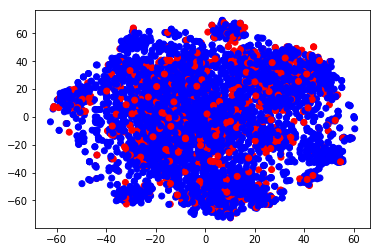

In [96]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((school_state_one_hot,clean_categories_one_hot, clean_subcategories_one_hot, teacher_prefix_categories_one_hot, project_grade_category_one_hot,avg_w2v_vectors,price_standardized,teacher_number))
#X_new2=X[0,500,:]
X.shape
from sklearn.manifold import TSNE
from sklearn import datasets
x=X.toarray()[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X1_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X1_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()


In [ ]:
# one hot encoding of the values in the columns school state,clean categories,clean subcategories,teachers prefix categories,project grade category are stacked together.
#the average word to vector of project title category, price column from resources dataset is standardised, number of teacher column which is numerical ,all these columns are stacked with the above mentioned one hot encoding column
#t-sne plot on all these stacked columns show that blue points are more denser than red points, and they are in different clusters closer to each other,
#this shows that approved number of projects for all these columns stacked together is higher in than number of projects which were not approved

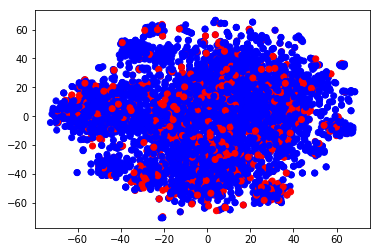

In [97]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((school_state_one_hot,clean_categories_one_hot, clean_subcategories_one_hot, teacher_prefix_categories_one_hot, project_grade_category_one_hot,tfidf_w2v_vectors,price_standardized,teacher_number))
#X_new3=X[0,5000,:]
from sklearn.manifold import TSNE
from sklearn import datasets
x=X.toarray()[:5000]
y=donors_dataset['project_is_approved'][:5000]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X1_embedding = tsne.fit_transform(x)
for_tsne = np.hstack((X1_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()


In [98]:
# one hot encoding of the values in the columns school state,clean categories,clean subcategories,teachers prefix categories,project grade category are stacked together.
#the term frequency/inverse document frequency word to vector of project title category, price column from resources dataset is standardised, number of teacher column which is numerical ,all these columns are stacked with the above mentioned one hot encoding column
#t-sne plot on all these stacked columns show that blue points are more denser than red points, as it oves away from center few clusters are formed
#this shows that approved number of projects for all these columns stacked together is higher in than number of projects which were not approved

In [99]:
#Summary:- all the 8 t-sne plots shows that the number of projects approved is higher in number than number of projects which is not approved 
#there are 15917 number of words which is common to glove vector and corpus which is 94.5%. Total number of words in corpus is 473560
# out of which there are 16903  unique words.
#the word2vec length is 15917
#the mean and standard deviation  of standarized version of  'price' column and 'number of previously approved projects column' donors dataset are 298.1 and 367.5, so the mean and standard deviation is same for both
#the shape of school_state categories is highest with 49 categories whereas shape of project_grade catgeory is lowest with 3 categories
#number of  projects which are not approved at 50th and 75th is higher than  projects which are approved,but number of projects approved at 100 percentile is higher than number of projects which are not approved

